In [15]:
import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [16]:
import torch
import torch.nn as nn

import numpy as np 

import matplotlib.pyplot as plt

import time
import random

from pinns import Trainer
from pinns.models import FF, KAN
from pinns.errors import l2
from pinns.optimizers import Adam
from pinns.derivatives import Derivative
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

from prettytable import PrettyTable

In [17]:
path = './examples/diff1d/'

def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

diff_constraints_sampler = ConstantSampler(get_data(path))

diff_domain = {'t': [0, 0.5], 'x': [0, 1]}
diff_collocation_sampler = RandomSampler(diff_domain, 2048, return_dict=True)

diff_test_points_sampler = DataSampler(path + 'solution.npy', 1024, 2)

In [18]:
d = Derivative(method='autograd')

def diff_loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.5
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    # If we use RandomSampler, we are unable to split values
    # like that. But it is just for clarity.
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        
        return torch.mean(torch.square(ut - D * uxx))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [19]:
Nt, Nx = 500, 750
pts, values = diff_test_points_sampler(full=True)

pts = [
    pts[:,0].reshape(Nx, Nt),
    pts[:,1].reshape(Nx, Nt)
]
values = values.reshape(Nx, Nt)

cstr_pts, cstr_vals = diff_constraints_sampler()
stacked_pts = torch.cat([torch.hstack([t[:, [1]], t[:, [0]]]) for t in cstr_pts])
stacked_vals = torch.cat(cstr_vals)
constraints = torch.hstack([stacked_pts, stacked_vals.reshape(-1, 1)]).T

def train(random_seed):

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)

    pinn = KAN([2, 5, 1], grid = 5, seed = random_seed)
    
    trainer = Trainer(
        diff_loss,
        pinn,
        diff_constraints_sampler,
        diff_collocation_sampler,
        loss_coefs=[0.75, 0.75, 0.75, 0.25],    # Coefficients are very important.
        test_points_sampler=diff_test_points_sampler
    )
    
    for i, (grid, it) in enumerate([(5, 250), (20, 250)]):
    
        points, _ = diff_test_points_sampler(full = True)

        pinn = KAN([2, 5, 1], grid = grid).initialize_from_another_model(trainer.model, points)
        trainer.model = pinn
            
        adam = Adam(pinn, lr = 1e-2)
        
        # trainer.iter += 1
        trainer.train(
            num_iters = it,
            optimizers=[(0, adam)]
        )
    
    pinn.model.plot(scale = 2, beta = 1000)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

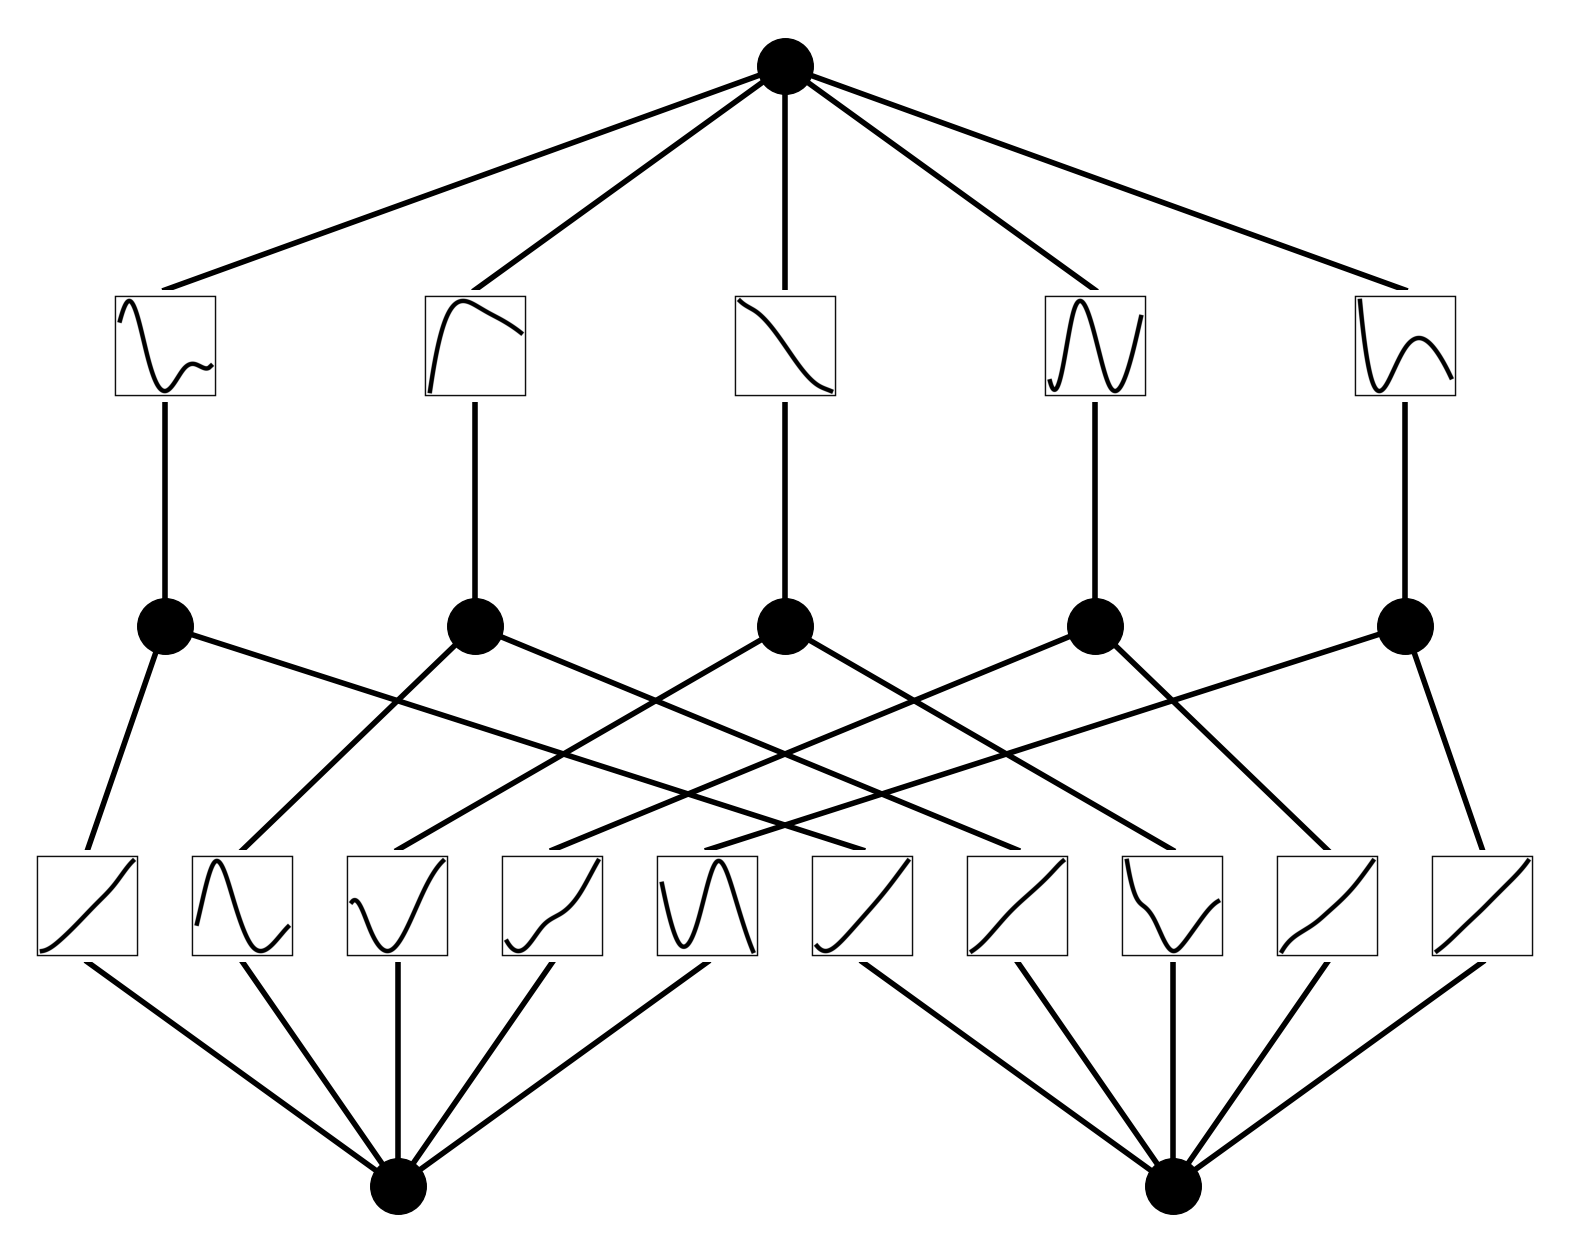

In [20]:
train(0)
plt.savefig('./kan_0.png') 

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

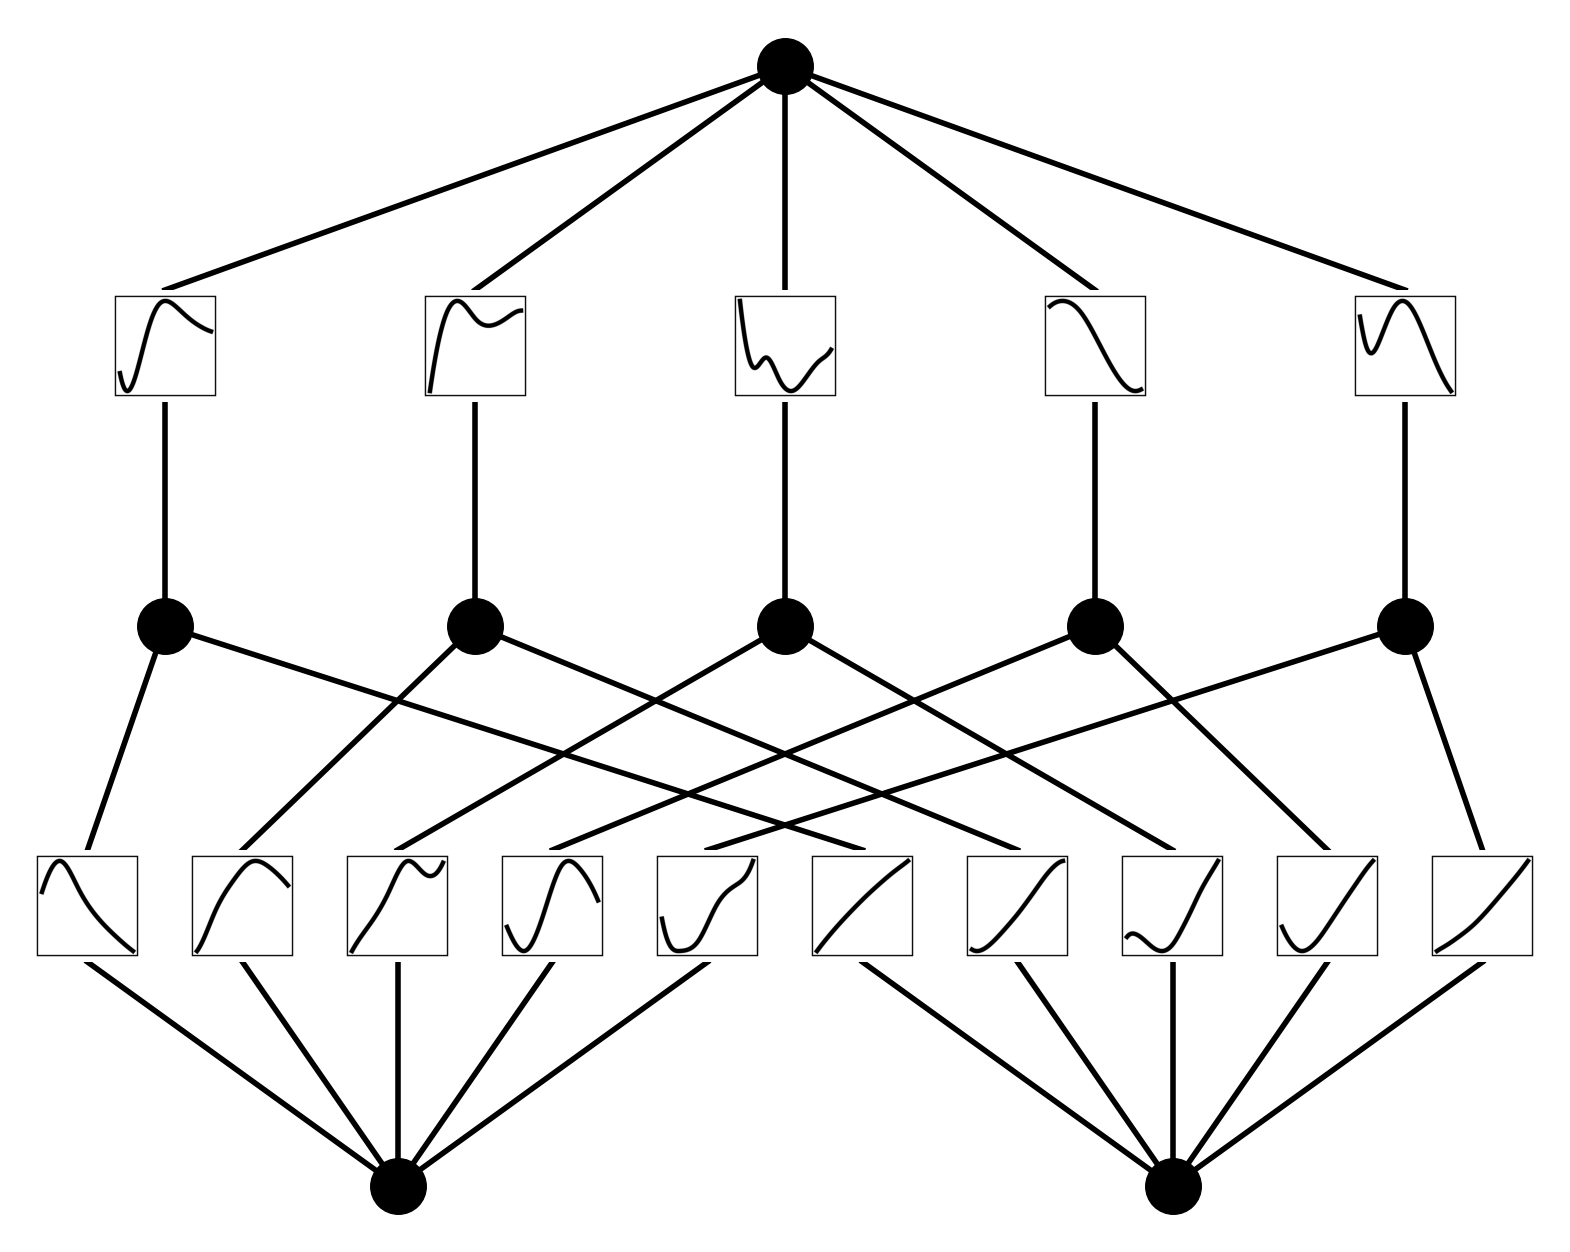

In [21]:
train(42)
plt.savefig('./kan_42.png')

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

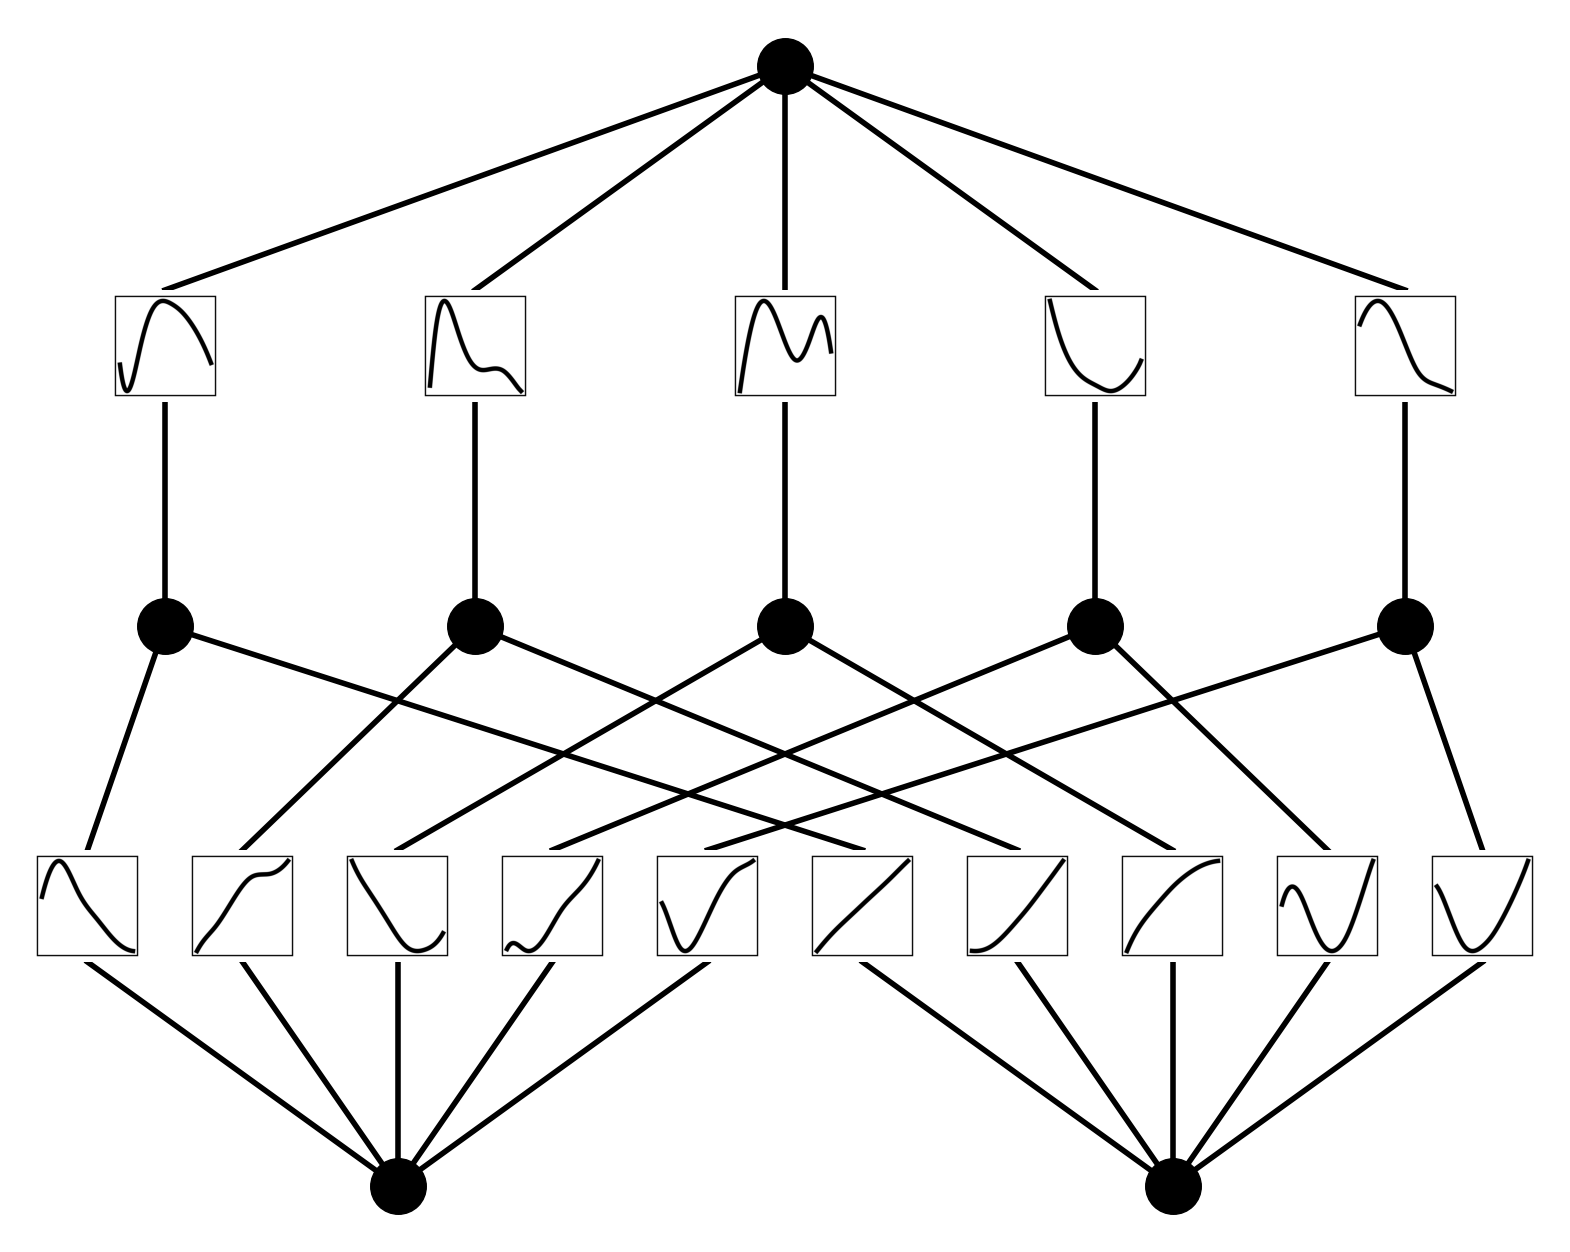

In [22]:
train(64)
plt.savefig('./kan_64.png')

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

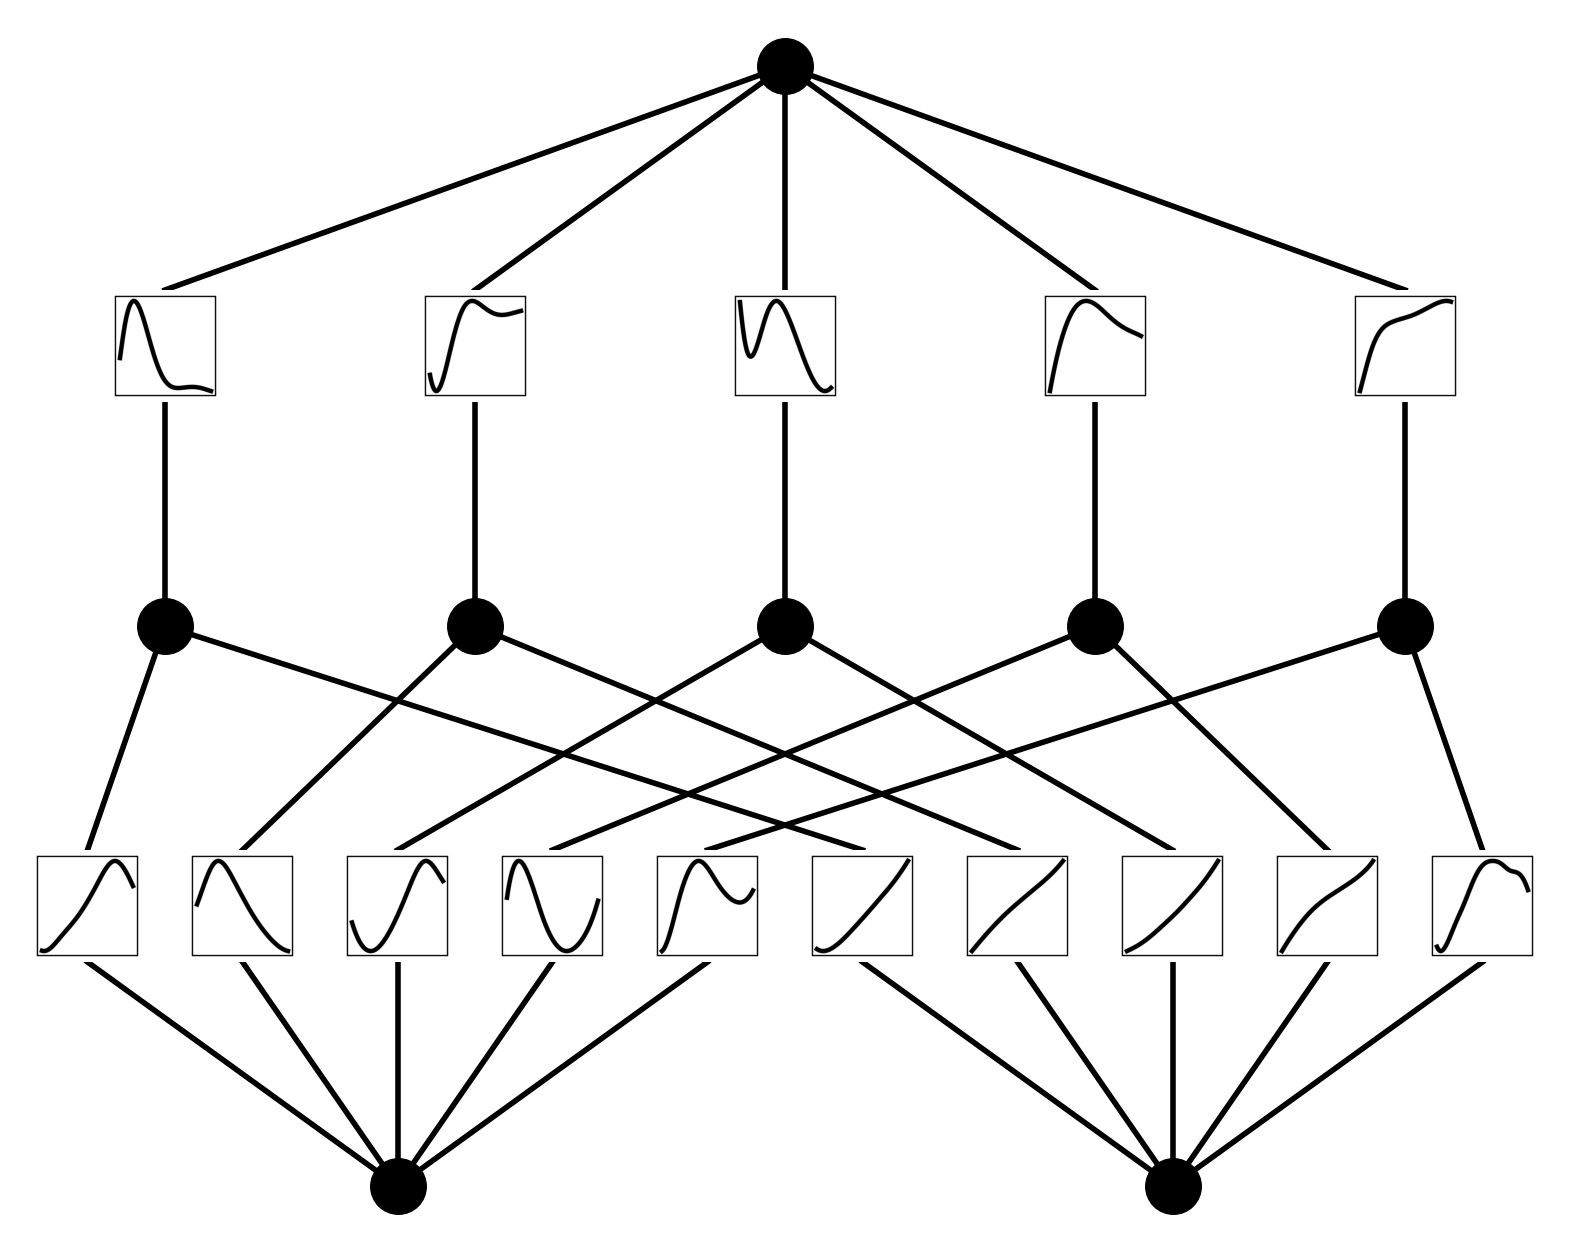

In [23]:
train(128)
plt.savefig('./kan_128.png')

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

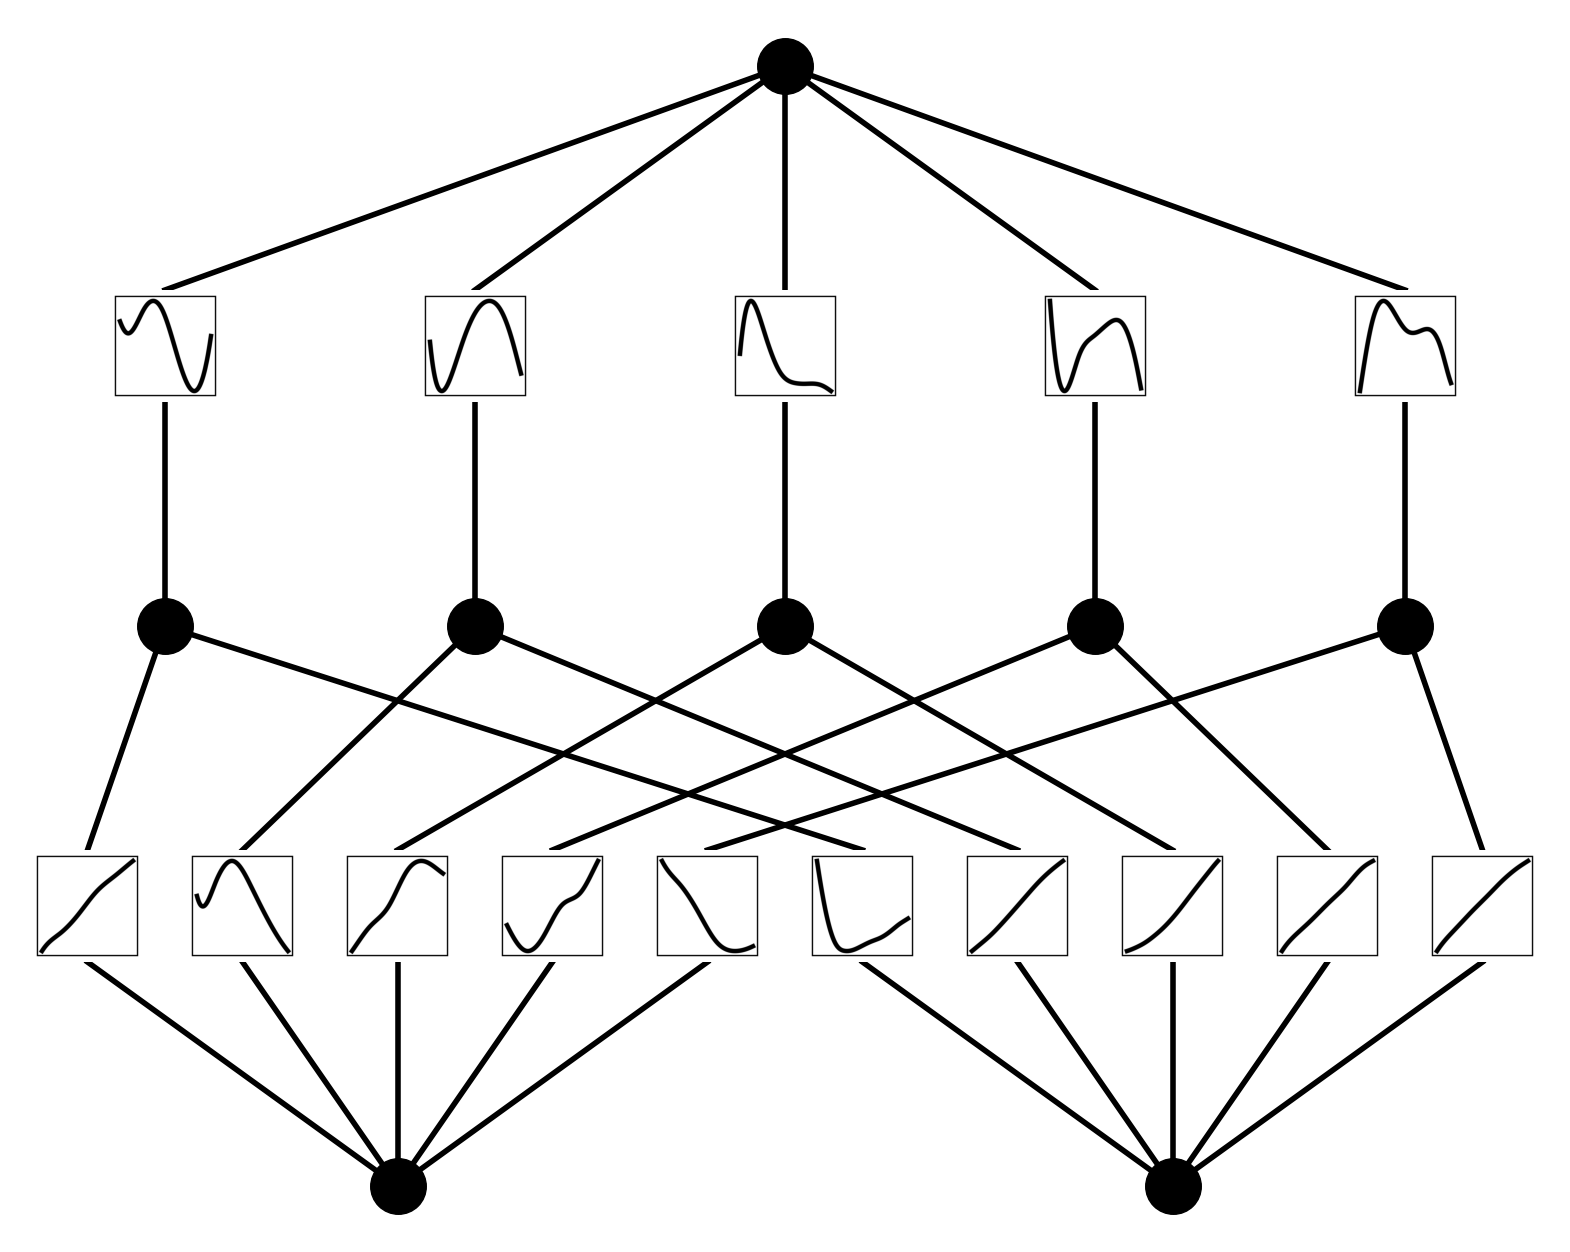

In [24]:
train(256)
plt.savefig('./kan_256.png')

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

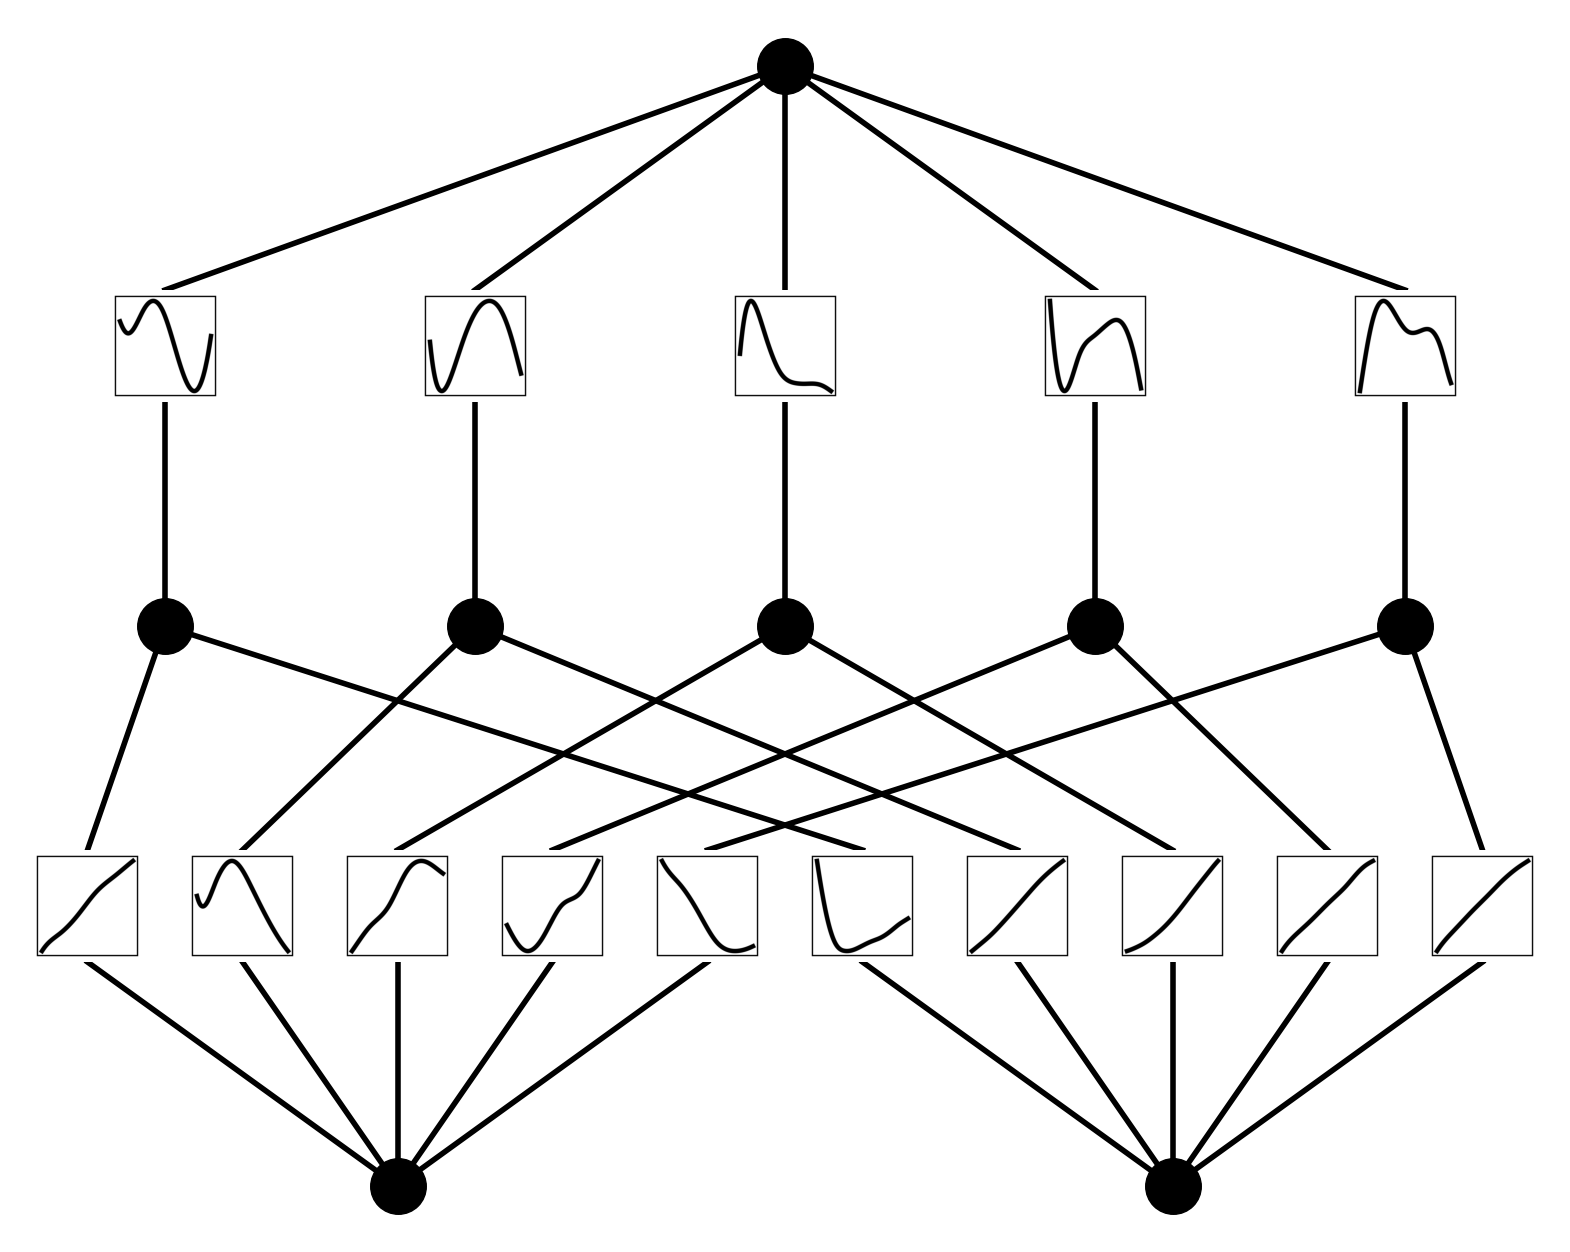

In [25]:
train(256)
plt.savefig('./kan_256_2.png')